# Import libraries:

In [1]:
from SBS_functions import *
import random
import pickle
from matplotlib.cm import get_cmap

# Exploring Different Initial States:

## Maximally-mixed initial state:

initial state:


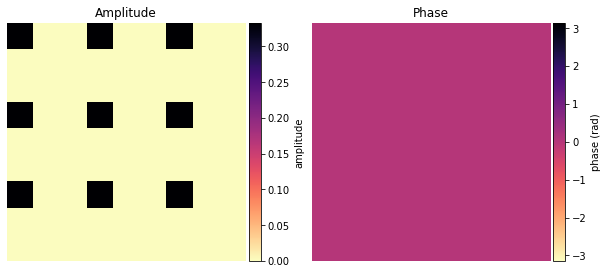

equilibrium state:


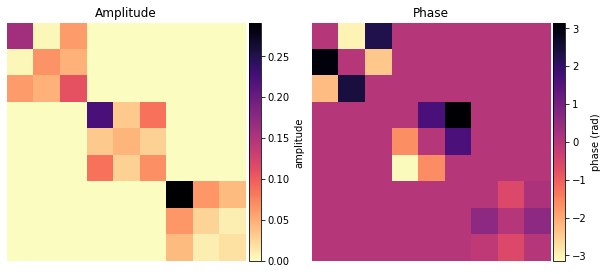

In [4]:
# parameters
system_dim = 3
env_dim = 3
environment_dims = [env_dim]*1
number_of_environments = len(environment_dims)

# state and H generation
initial = initial_state(system_dim, number_of_environments, env_dim)
H = total_hamiltonian_GUE(system_dim, number_of_environments, env_dim)
rho_inf = infinite_time_average_state_given_H(initial, H, system_dim, env_dim, environment_dims)

print('initial state:')
plot_complex_Qutip(initial)
plt.show()

print('equilibrium state:')
plot_complex(rho_inf)
plt.show()


- what is the trace distance $T(\rho_{\infty},\rho_{\infty}^{SBS})$ for the max mixed state?

equilibrium state:


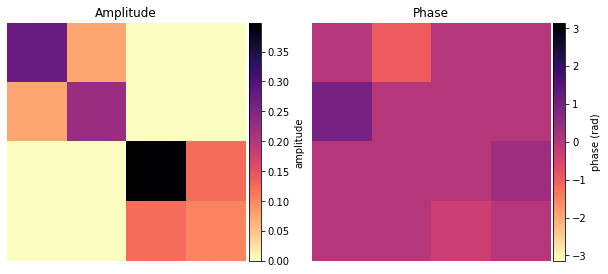

nearest SBS state:


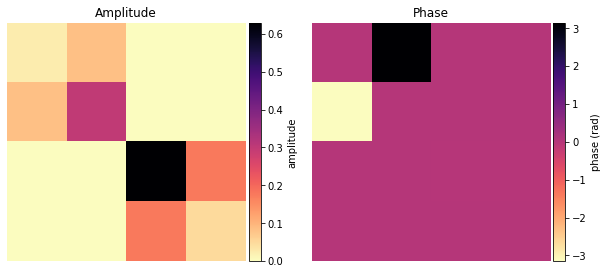

trace distance between equilibrium state and nearest SBS state:


0.3726464534517465

In [5]:
#parameters:
system_dim = 2
env_dim = 2
environment_dims = [env_dim]*1
number_of_environments = len(environment_dims)

# state and H generation
initial = initial_state(system_dim, number_of_environments, env_dim)
H = total_hamiltonian(system_dim, number_of_environments, env_dim)
rho_inf = infinite_time_average_state_given_H(initial, H, system_dim, env_dim, environment_dims)

# optimisation to find SBS state
projs = find_projectors(rho_inf, environment_dims, dim_sys=2)
rho_SBS, q = generate_candidate_SBS_state(rho_inf, projs, environment_dims, dim_sys=2)

print('equilibrium state:')
plot_complex(rho_inf)
plt.show()

print('nearest SBS state:')
plot_complex(rho_SBS)
plt.show()

print('trace distance between equilibrium state and nearest SBS state:')
trace_distance(rho_inf, rho_SBS)

## Separable initial state (everything in ground state)
- This will depend on the eigenvectors of the random Hamiltonians. 
- The effective dimension will depend on how much the eigenvectors overlap with the ground state for each environment
- For a pure initial state:
$$
\left\langle \frac{1}{\sqrt{d_{\mathrm{eff}}}} \right\rangle_{GUE} = \frac{1}{4} \left\langle \sqrt{ \sum_{i} \prod_{k}\sum_{n_k} \langle E_{n_k}^{i} | \psi_{k}\rangle^{4} } \right\rangle_{GUE}
$$

Separable initial state (everything in an eigenstate of the Hamiltonian)
- Let $\rho_{S,0} = |0\rangle \langle 0|$
- Let $\rho_{k,0} = |E_{0}^{(0)}\rangle \langle E_{0}^{(0)}|$ $\forall$ $k$. This is the first eigenstate of each conditional Hamiltonian $H_{k}^{(i=0)}$, corresponding to $i=0$.

- Why can we not achieve maximium effective dimension? Because the Ham will keep the system in the |0><0| state for all time, so we dont explore all the state space for the system.


initial state:


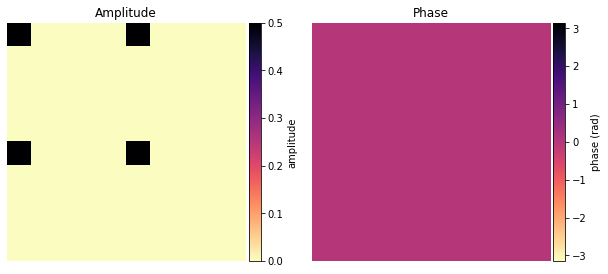

equilibrium state:


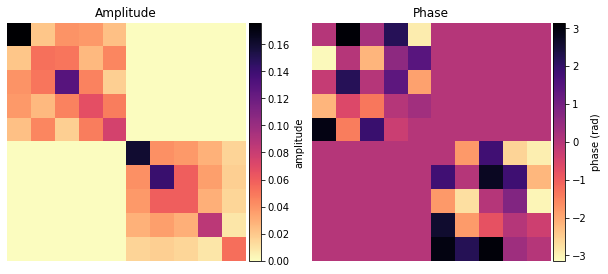

sys-env dimension:
10
effective dimension:
5.952843481612653


In [12]:
# Draw conditional Hams randomly using GUE:

#parameters:
system_dim = 2
env_dim = 5
environment_dims = [env_dim]*1
number_of_environments = len(environment_dims)

# state and H generation
initial = initial_state(system_dim, number_of_environments, env_dim)
H = total_hamiltonian_GUE(system_dim, number_of_environments, env_dim)
rho_inf = infinite_time_average_state_given_H(initial, H, system_dim, env_dim, environment_dims)

print('initial state:')
plot_complex_Qutip(initial)
plt.show()

print('equilibrium state:')
plot_complex(rho_inf)
plt.show()

print('sys-env dimension:')
print(system_dim*(env_dim**number_of_environments))
print('effective dimension:')
print(deff(initial,H))



# The Effective Dimension
## Calculating the Effective Dimension Directly:

In [23]:
# number of random interactions
n = 100

# parameters
system_dim = 2
env_dim = 2
environment_dims = [env_dim]*1
number_of_environments = len(environment_dims)

# all env initially in the ground state - sys in equal superposition:
initial = initial_state(system_dim, number_of_environments, env_dim)

deffs = []
for i in range(n):
    H = total_hamiltonian_GUE(system_dim, number_of_environments, env_dim)
    deffs.append(deff(initial,H))
    


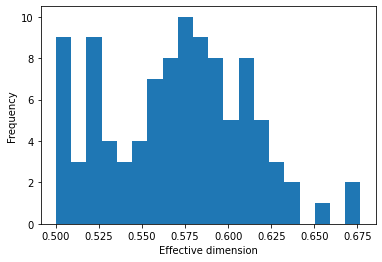

In [25]:
plt.hist(1/np.sqrt(deffs), bins=20)
plt.ylabel('Frequency')
plt.xlabel('Effective dimension')
plt.show()

## Calculating the Simplified Effective Dimension

- This will be much faster than using deff()
- We can calculate the effective dimension directly as
$$
d_{\mathrm{eff}} = \frac{1}{ \sum_{i} \langle i | \rho_{S,0} | i \rangle^{2} \prod_{k}\sum_{n_k} \langle E_{n_k}^{i} | 0\rangle^{4} }.
$$
Focussing on the $\langle E_{n_k}^{i} | 0\rangle^{4}$ term in the denominator, we want a fast way to calculate this for general 
$$
    \frac{1}{ \sqrt{d_{\mathrm{eff}}}} = \sqrt{ \sum_{i} \langle{i}| \rho_{S,0}|i\rangle^{2}\prod_{k}\sum_{n_k} \langle E_{n_k}^{i} | \psi_{k}\rangle^{4} } 
$$
system in equal superposition gives us:
$$
    \frac{1}{ \sqrt{d_{\mathrm{eff}}}} = \frac{1}{2} \sqrt{ \sum_{i}\prod_{k}\sum_{n_k} \langle E_{n_k}^{i} | \psi_{k}\rangle^{4} } 
$$

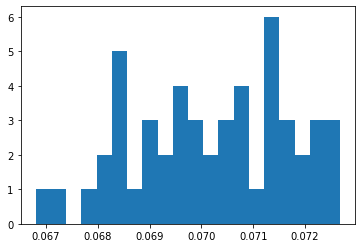

In [58]:
# this function only works for:
# d_s=2, 
# equal superposition system initially
# a single environment 
# any d_env

N = 50
d_env = 200
d_S = 2
H1 = GUE(d_env)
H2 = GUE(d_env)
eigvals, eigvecs1 = np.linalg.eig(H1)
eigvals, eigvecs2 = np.linalg.eig(H2)

inner_prods = []
for n in range(N):
    H1 = GUE(d_env)
    H2 = GUE(d_env)
    eigvals, eigvecs1 = np.linalg.eig(H1)
    eigvals, eigvecs2 = np.linalg.eig(H2)
    sum_inner_prods1 = 0
    for nk in range(d_env):
        # sum over eigvecs in single env, i.e. sum_{nk}
        sum_inner_prods1 = sum_inner_prods1 +  np.abs(np.dot(eigvecs1[:,nk] , basis(d_env,0)))**4
    sum_inner_prods2 = 0
    for nk in range(d_env):
        # sum over eigvecs in single env, i.e. sum_{nk}
        sum_inner_prods2 = sum_inner_prods2 +  np.abs(np.dot(eigvecs2[:,nk] , basis(d_env,0)))**4

    inner_prods.append(1/2 *  np.sqrt(sum_inner_prods1 + sum_inner_prods2))

#np.shape(inner_prods)
inner_prods = np.array(inner_prods).reshape(N)
plt.hist(inner_prods, 20)
plt.show()

# Figure 3 in Paper:

- 2 cases:
- Fix number of envs = 1, dim_sys = 2, vary env_dim - single qudit environment
- Fix dim_sys=2, dim_env = 2, vary number of envs - many qubits environment


## Case 1: Vary Environment Dimension

- This is Fig 3b in the manuscript.

environment dimension = 2


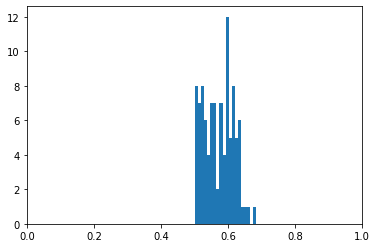

environment dimension = 3


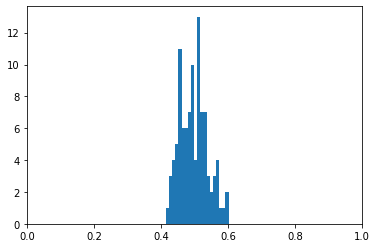

environment dimension = 8


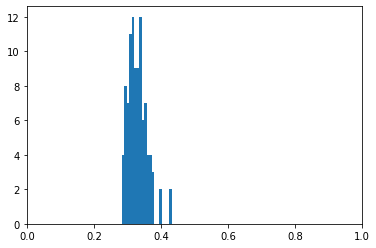

environment dimension = 16


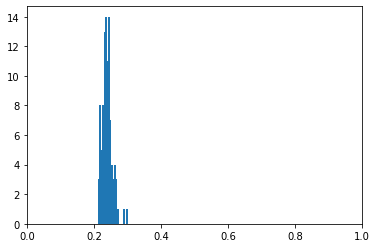

environment dimension = 32


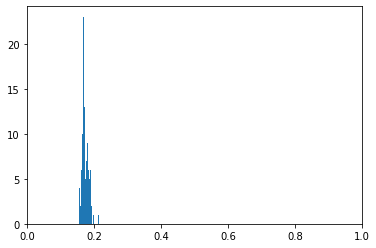

CPU times: user 1.91 s, sys: 1.09 s, total: 3 s
Wall time: 1.63 s


In [26]:
%%time

# environment dims to loop through
env_dims = [2,3,8,16,32] # test data (quicker than running all dims up to 1024)
# env_dims = [2,4,8,16,32,64,128,256,512,1024]

# number of random interactions in each histogram
Ns = [100, 100, 100, 100, 100] # test data
#Ns = [10000,10000,10000,10000,10000,10000,10000,10000,10000,10000]

deff_terms = []
deff_term_means = []
for i in range(len(env_dims)):
    env_dim = env_dims[i]
    system_dim = 2
    environment_dims = [env_dim]*1
    number_of_environments = len(environment_dims)
    N = Ns[i]

    X_is = []
    for j in range(system_dim):
        X_k = []
        for k in range(number_of_environments):
            X_k.append(random_variable_X(env_dim, N))
        X_k_prod = np.prod(X_k, axis=0)
        X_is.append(X_k_prod)

    X_ki = np.sum(X_is, axis=0)

    deff_term = 0.5 * np.sqrt(X_ki)
    deff_term_mean = np.mean(deff_term)
    deff_term_means.append(deff_term_mean)
    deff_terms.append(deff_term)
    
    print('environment dimension =', env_dim)
    plt.hist(deff_term, 20)
    plt.xlim(0,1)
    plt.show()

### Pickle data:

In [22]:
# pickling the data

# import pickle
# filename = 'deff_vary_dE_10000N_512_1024dims_07_06_2023'
# data = {'d_E' :env_dims, 'deff means': deff_term_means, 'd_eff': deff_terms, 'Ns':Ns, }
# file = open(filename, 'wb')
# # dump information to that file
# pickle.dump(data, file)
# # close the file
# file.close()

### Load pickled data and generate figure:

Text(0, 0.5, 'Frequency')

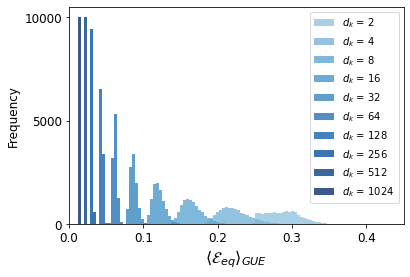

In [27]:
import pickle

file = open('deff_vary_dE_10000N_2_4_8_16dims_07_06_2023', 'rb')
file32 = open('deff_vary_dE_10000N_32_64_128dims_07_06_2023', 'rb')
file256 = open('deff_vary_dE_10000N_256dims_07_06_2023', 'rb')
file512 = open('deff_vary_dE_10000N_512_1024dims_07_06_2023', 'rb')

data = pickle.load(file)
file.close()
data32 = pickle.load(file32)
file32.close()
data256 = pickle.load(file256)
file256.close()
data512 = pickle.load(file512)
file512.close()

env_dims = data['d_E']
deff_term_means = data['deff means']
deff_terms = data['d_eff']
Ns = data['Ns']

env_dims32 = data32['d_E']
deff_term_means32 = data32['deff means']
deff_terms32 = data32['d_eff']
Ns32 = data32['Ns']

env_dims256 = data256['d_E']
deff_term_means256 = data256['deff means']
deff_terms256 = data256['d_eff']
Ns256 = data256['Ns']

env_dims512 = data512['d_E']
deff_term_means512 = data512['deff means']
deff_terms512 = data512['d_eff']
Ns512 = data512['Ns']

[ env_dims.append(env_dims32[i]) for i in range(len(env_dims32)) ]
[ env_dims.append(env_dims256[i]) for i in range(len(env_dims256)) ]
[ env_dims.append(env_dims512[i]) for i in range(len(env_dims512)) ]

[ deff_term_means.append(deff_term_means32[i]) for i in range(len(deff_term_means32)) ]
[ deff_term_means.append(deff_term_means256[i]) for i in range(len(deff_term_means256)) ]
[ deff_term_means.append(deff_term_means512[i]) for i in range(len(deff_term_means512)) ]


[ deff_terms.append(deff_terms32[i]) for i in range(len(deff_terms32)) ]
[ deff_terms.append(deff_terms256[i]) for i in range(len(deff_terms256)) ]
[ deff_terms.append(deff_terms512[i]) for i in range(len(deff_terms512)) ]

[ Ns.append(Ns32[i]) for i in range(len(Ns32)) ]
[ Ns.append(Ns256[i]) for i in range(len(Ns256)) ]
[ Ns.append(Ns512[i]) for i in range(len(Ns512)) ]

deff_terms[8] = np.array([deff_terms[8]]*1000).reshape(10000)
deff_terms[9] = np.array([deff_terms[9]]*1000).reshape(10000)

bins = np.linspace(0, 0.4, 100)

# Create a sequential blue colormap
cmap = get_cmap('Blues')

# Define the range of colors to use (e.g., the darkest 50%)
color_range = np.linspace(0.4, 1.0, len(env_dims))


for i in range(len(env_dims)):
    #plt.hist(0.5*deff_terms[i], bins, label=f'd = {env_dims[i]}', alpha=0.8)
    color = cmap(color_range[i])  # Get a color from the colormap within the specified range
    plt.hist(0.5*deff_terms[i], bins, alpha=0.8, label=f'$d_k$ = {env_dims[i]}', color=color)
    
# Set custom ticks on the x-axis
custom_xticks = [0, 0.1, 0.2,0.3, 0.4]
plt.xticks(custom_xticks, fontsize=12)

# Set custom ticks on the y-axis
custom_yticks = [0, 5000, 10000]
plt.yticks(custom_yticks, fontsize=12)

plt.xlim(0,0.45)
plt.legend()#title=r'Environment dimension $d_{E}$:')#,loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$\left\langle \mathcal{E}_{eq}\right\rangle_{GUE}$', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
#plt.savefig('qudits_deff_blues.svg')
#plt.savefig('qudits_deff_blues_paper_24_12_23.svg', bbox_inches='tight', dpi=300)
#plt.show()



## Case 2: Vary Number of Environmental Qubits

- This is Fig 3a in the manuscript

no of envs = 1


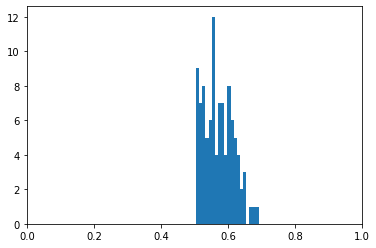

no of envs = 2


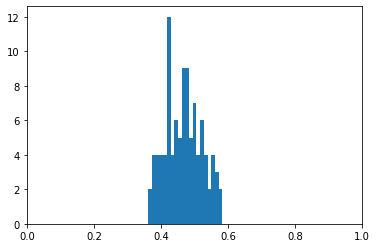

no of envs = 3


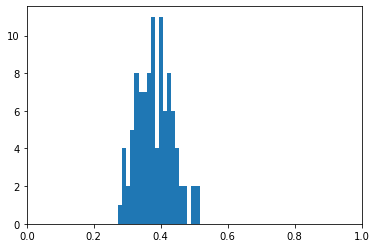

no of envs = 4


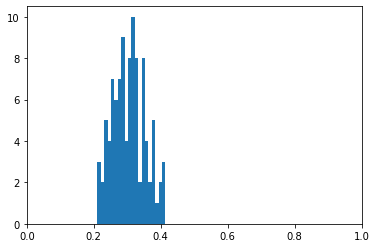

no of envs = 5


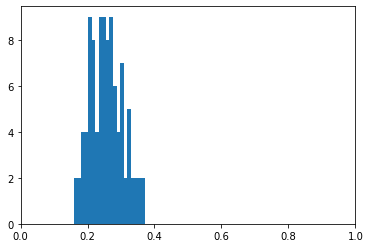

CPU times: user 1.57 s, sys: 1.08 s, total: 2.65 s
Wall time: 1.2 s


In [28]:
%%time

number_of_envs = [1,2,3,4,5] # test data
#number_of_envs = [1,2,3,4,5,6,7,8,9,10]

# number of random interactions per histogram
N = 100
Ns = [N]*len(number_of_envs)

eqiv_tot_dim = 2**np.array(number_of_envs)
env_dim = 2
system_dim = 2

deff_terms = []
deff_term_means = []
for i in range(len(number_of_envs)):
    Nk = number_of_envs[i]
    N = Ns[i]
    environment_dims = [env_dim]*Nk
    number_of_environments = len(environment_dims)
    
    X_is = []
    for j in range(system_dim):
        X_k = []
        for k in range(number_of_environments):
            X_k.append(random_variable_X(env_dim, N))
        X_k_prod = np.prod(X_k, axis=0)
        X_is.append(X_k_prod)

    X_ki = np.sum(X_is, axis=0)

    deff_term = 0.5 * np.sqrt(X_ki)
    deff_term_mean = np.mean(deff_term)
    deff_term_means.append(deff_term_mean)
    deff_terms.append(deff_term)
    
    print('no of envs =', number_of_environments)
    plt.hist(deff_term, 20)
    plt.xlim(0,1)
    plt.show()

### Pickle data:

In [29]:
#pickle_data('deff_term_means_N1000_26_05_2023', {'d_E' :env_dims, 'deff means': deff_term_means})

# import pickle
# filename = 'deff_term_means_N10000_vary_no_envs_01_06_2023'
# data = {'no_envs' :number_of_envs, 'deff means': deff_term_means,'d_eff': deff_terms, 'Ns':Ns, }
# file = open(filename, 'wb')
# # dump information to that file
# pickle.dump(data, file)
# # close the file
# file.close()

### Load pickled data and generate figure:

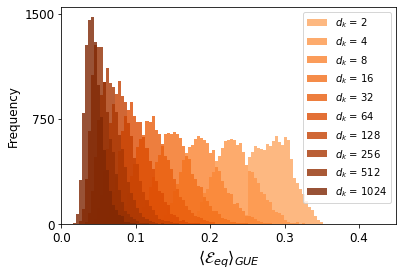

In [30]:
# open a file, where you stored the pickled data
#file = open('deff_term_means_N1000_vary_no_envs_26_05_2023', 'rb')
#file = open('deff_term_means_N1000_vary_no_envs_30_05_2023', 'rb')
file = open('deff_term_means_N10000_vary_no_envs_01_06_2023', 'rb')

# dump information to that file
data = pickle.load(file)
# close the file
file.close()
number_of_envs = data['no_envs']
deff_term_means = data['deff means']
deff_terms = data['d_eff']
Ns = data['Ns']

env_dims = 2**np.array(number_of_envs)

bins = np.linspace(0, 0.4, 100)

# Create a sequential blue colormap
cmap = get_cmap('Oranges')

# Define the range of colors to use (e.g., the darkest 50%)
color_range = np.linspace(0.4, 1.0, len(env_dims))

# Set custom ticks on the x-axis
custom_xticks = [0, 0.1, 0.2,0.3, 0.4]
plt.xticks(custom_xticks, fontsize=12)

# Set custom ticks on the y-axis
custom_yticks = [0, 750, 1500]
plt.yticks(custom_yticks, fontsize=12)

for i in range(len(env_dims)):
    #plt.hist(0.5*deff_terms[i], bins, label=f'd = {env_dims[i]}', alpha=0.8)
    color = cmap(color_range[i])  # Get a color from the colormap within the specified range
    plt.hist(0.5*deff_terms[i], bins, alpha=0.8, label=f'$d_k$ = {env_dims[i]}', color=color)

plt.xlim(0,0.45)
plt.xlabel(r'$\left\langle \mathcal{E}_{eq}\right\rangle_{GUE}$', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.legend()


## Comparing Case 1 and Case 2:

- comparing means and variances for Cases 1 and 2.
- This is figures 3c and 3d in the manuscript

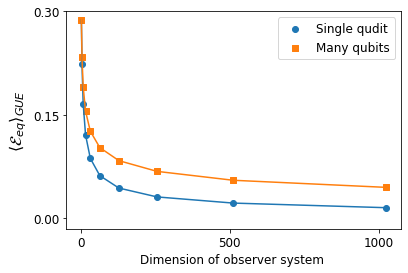

In [34]:
#Case 1:
# open a file, where you stored the pickled data
#file = open('deff_term_means_Nchanges_vary_dE__1024dims_30_05_2023', 'rb')
file = open('deff_vary_dE_10000N_2_4_8_16dims_07_06_2023', 'rb')
file32 = open('deff_vary_dE_10000N_32_64_128dims_07_06_2023', 'rb')
file256 = open('deff_vary_dE_10000N_256dims_07_06_2023', 'rb')
file512 = open('deff_vary_dE_10000N_512_1024dims_07_06_2023', 'rb')

data = pickle.load(file)
file.close()
data32 = pickle.load(file32)
file32.close()
data256 = pickle.load(file256)
file256.close()
data512 = pickle.load(file512)
file512.close()

env_dims1 = data['d_E']
deff_term_means1 = data['deff means']
deff_terms1 = data['d_eff']
Ns1 = data['Ns']

env_dims32 = data32['d_E']
deff_term_means32 = data32['deff means']
deff_terms32 = data32['d_eff']
Ns32 = data32['Ns']

env_dims256 = data256['d_E']
deff_term_means256 = data256['deff means']
deff_terms256 = data256['d_eff']
Ns256 = data256['Ns']

env_dims512 = data512['d_E']
deff_term_means512 = data512['deff means']
deff_terms512 = data512['d_eff']
Ns512 = data512['Ns']

[ env_dims1.append(env_dims32[i]) for i in range(len(env_dims32)) ]
[ env_dims1.append(env_dims256[i]) for i in range(len(env_dims256)) ]
[ env_dims1.append(env_dims512[i]) for i in range(len(env_dims512)) ]

[ deff_term_means1.append(deff_term_means32[i]) for i in range(len(deff_term_means32)) ]
[ deff_term_means1.append(deff_term_means256[i]) for i in range(len(deff_term_means256)) ]
[ deff_term_means1.append(deff_term_means512[i]) for i in range(len(deff_term_means512)) ]

[ deff_terms1.append(deff_terms32[i]) for i in range(len(deff_terms32)) ]
[ deff_terms1.append(deff_terms256[i]) for i in range(len(deff_terms256)) ]
[ deff_terms1.append(deff_terms512[i]) for i in range(len(deff_terms512)) ]

[ Ns1.append(Ns32[i]) for i in range(len(Ns32)) ]
[ Ns1.append(Ns256[i]) for i in range(len(Ns256)) ]
[ Ns1.append(Ns512[i]) for i in range(len(Ns512)) ]

#Case 2:
#file = open('deff_term_means_N1000_vary_no_envs_30_05_2023', 'rb')
file = open('deff_term_means_N10000_vary_no_envs_01_06_2023', 'rb')
# dump information to that file
data = pickle.load(file)
# close the file
file.close()
number_of_envs2 = data['no_envs']
deff_term_means2 = data['deff means']
deff_terms2 = data['d_eff']
Ns2 = data['Ns']
env_dims2 = 2**np.array(number_of_envs2)

plt.plot(np.array(env_dims1), 0.5*np.array(deff_term_means1), '-')
plt.scatter(np.array(env_dims1), 0.5*np.array(deff_term_means1), marker='o',label='Single qudit')

# # Set custom ticks on the y-axis
custom_yticks = [0, 0.15, 0.3]
plt.yticks(custom_yticks, fontsize=12)

# # Set custom ticks on the x-axis
custom_xticks = [0, 500, 1000]
plt.xticks(custom_xticks, fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set the upper limit of the y-axis without changing the lower limit
new_upper_limit = 0.3  # Adjust as needed
plt.ylim(plt.ylim()[0], new_upper_limit)

# Add different margins to the top and bottom of the y-axis
margin_bottom = 0.015  # Adjust as needed
margin_top = 0.00000  # Adjust as needed

plt.ylim(plt.ylim()[0] - margin_bottom, plt.ylim()[1] + margin_top)

plt.plot(2**np.array(number_of_envs2), 0.5*np.array(deff_term_means2), '-')#, label='Many qubit envs')
plt.scatter(2**np.array(number_of_envs2), 0.5*np.array(deff_term_means2),marker=',', label='Many qubits')
#plt.ylim(0,0.3)
plt.xlabel(r'Dimension of observer system ', fontsize=12)
plt.ylabel(r'$\left\langle \mathcal{E}_{eq}\right\rangle_{GUE}$', fontsize=16)
plt.legend(fontsize=12)

#plt.savefig('eff_dim_term_average_comparison_qubit_vs_qudit_24_12_2023.svg', bbox_inches='tight', dpi=300)
#plt.show()

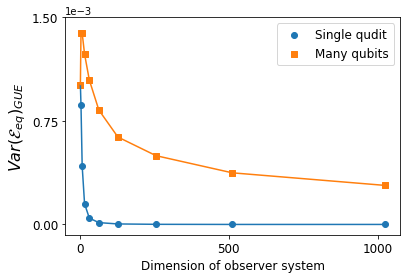

In [35]:
# variances case 1
deff_variances1 = []
for i in range(len(env_dims1)):
    var = np.var(np.array(deff_terms1[i]))
    deff_variances1.append(var)
    
# variances case 2
deff_variances2 = []
for i in range(len(env_dims2)):
    var = np.var(np.array(deff_terms2[i]))
    deff_variances2.append(var)
    
from matplotlib.ticker import ScalarFormatter

# Set the x-axis tick formatter to use scientific notation
plt.tick_params(axis='x', which='both', labelsize=12)
plt.tick_params(axis='y', which='both', labelsize=12)

#plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Set the upper limit of the y-axis without changing the lower limit
#plt.ylim(bottom=plt.ylim()[0], top=0.003)

# # Set custom ticks on the x-axis
custom_xticks = [0, 500, 1000]
plt.xticks(custom_xticks, fontsize=12)

# # Set custom ticks on the y-axis
custom_yticks = [0, 0.5*0.0015, 0.5*0.003]
plt.yticks(custom_yticks, fontsize=12)

# #plt.ylim(0,0.003)
# plt.margins(y=0.11)

# Set the upper limit of the y-axis without changing the lower limit
new_upper_limit = 0.5*0.003  # Adjust as needed
plt.ylim(plt.ylim()[0], new_upper_limit)

# Add different margins to the top and bottom of the y-axis
margin_bottom = 0.5*0.00015  # Adjust as needed
margin_top = 0.00000  # Adjust as needed

plt.ylim(plt.ylim()[0] - margin_bottom, plt.ylim()[1] + margin_top)


plt.plot(np.array(env_dims1), 0.5*np.array(deff_variances1), '-')#, label='Single qudit env')
plt.scatter(np.array(env_dims1), 0.5*np.array(deff_variances1), marker='o',label='Single qudit')
plt.plot(np.array(env_dims2), 0.5*np.array(deff_variances2), '-')#, label='Many qubit envs')
plt.scatter(np.array(env_dims2), 0.5*np.array(deff_variances2),marker=',', label='Many qubits')

plt.xlabel('Dimension of observer system', fontsize=12)
plt.ylabel(r'$Var\left( \mathcal{E}_{eq}\right)_{GUE}$', fontsize=16) # \frac{1}{\sqrt{d_{eff}}}$ 

plt.legend(fontsize=12)

#plt.savefig('eff_dim_term_variance_comparison_qubit_vs_qudit_24_01_2024.svg', bbox_inches='tight', dpi=300)
#plt.show()